In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### load models and dependencies

In [2]:
# redefine the custom functions used in the model

from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
import tensorflow as tf

@tf.keras.utils.register_keras_serializable(package='Custom')
# Define the sample_z function
def sample_z(args):
    mu, sigma = args
    epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.0)
    return mu + K.exp(0.5 * sigma) * epsilon

@tf.keras.utils.register_keras_serializable(package='Custom')
class Sampling(Layer):
  def call(self, inputs):
      mu, sigma = inputs
      epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.0)
      return mu + K.exp(0.5 * sigma) * epsilon

In [3]:
## BCE

from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import register_keras_serializable
import tensorflow as tf
from tensorflow.keras import backend as K

@register_keras_serializable()
class VAELossLayer(Layer):
    def __init__(self, beta=1.0, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)
        self.beta = beta

    def call(self, inputs):
        original, reconstructed, mu, sigma = inputs
        # Flatten the input and reconstructed output for BCE calculation
        original = tf.reshape(original, [tf.shape(original)[0], -1])  # Dynamically handle batch size
        reconstructed = tf.reshape(reconstructed, [tf.shape(reconstructed)[0], -1])

        # Reconstruction loss using Binary Cross-Entropy (BCE)
        reconstruction_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(original, reconstructed)
        )

        # KL divergence loss
        kl_loss = -0.5 * K.sum(1 + sigma - K.square(mu) - K.exp(sigma), axis=-1)

        # Apply beta to the KL loss
        kl_loss = self.beta * kl_loss

        # Calculate the total loss
        total_loss = K.mean(reconstruction_loss + kl_loss)

        # Add the loss to the model
        self.add_loss(total_loss)

        # Return the reconstructed output
        return reconstructed

In [4]:
from tensorflow.keras.models import load_model


# Load the saved model
model = load_model("/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/vae_model_10_epochs_beta_7.h5", custom_objects={'sample_z': sample_z,'Sampling': Sampling,'VAELossLayer': VAELossLayer})

### Testing metrics

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Parameters
sequence_length = 30
image_height = 112
image_width = 112
num_channels = 1  # Assuming grayscale images
frame_step = 2    # Adjust as needed (e.g., 2 for skipping every other frame)
file_extension = '.avi'  # Replace with your actual file extension
batch_size = 2

In [ ]:
df = pd.read_csv( '/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/updated_file.csv')
video_dir = '/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/Videos/TEST/'

In [ ]:
# Initialize lists to collect results
reconstruction_errors = []
y_true = []

def load_and_preprocess_frames(video_path, sequence_length, image_height, image_width, num_channels, frame_step=1):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        cap.release()
        return None  # Cannot open video

    frames = []
    total_frames_read = 0

    while len(frames) < sequence_length:
        ret, frame = cap.read()
        if not ret:
            break  # End of video

        if total_frames_read % frame_step == 0:
            # Preprocess the frame
            frame = cv2.resize(frame, (image_width, image_height))
            if num_channels == 1:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                frame = frame[..., np.newaxis]
            else:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            frame = frame.astype(np.float32) / 255.0  # Normalize to [0, 1]
            frames.append(frame)

        total_frames_read += 1

    cap.release()

    # Handle cases where fewer frames were extracted
    if len(frames) < sequence_length:
        if frames:
            last_frame = frames[-1]
            while len(frames) < sequence_length:
                frames.append(last_frame)
        else:
            return None  # No frames were extracted

    sequence = np.array(frames)
    return sequence

### recontruction error l2 norm

In [ ]:
## l2 norm error testing
import numpy as np

# Process each video
for idx, row in tqdm(df.iterrows(), total=len(df), desc='Processing videos'):
    file_name = row['FileName']
    ef_status = row['EF_Status']  # 'N' or 'A'

    # Construct the full video path
    video_path = os.path.join(video_dir, f"{file_name}{file_extension}")

    # Check if the video file exists
    if not os.path.exists(video_path):
        print(f"Warning: Video file not found and skipped: {video_path}")
        continue

    # Load and preprocess frames
    sequence = load_and_preprocess_frames(
        video_path=video_path,
        sequence_length=sequence_length,
        image_height=image_height,
        image_width=image_width,
        num_channels=num_channels,
        frame_step=frame_step
    )

    if sequence is None:
        print(f"Warning: Could not load frames from video: {video_path}")
        continue

    # Add batch dimension
    sequence = np.expand_dims(sequence, axis=0)  # Shape: (1, sequence_length, height, width, channels)

    # Predict reconstruction
    reconstructed_sequence = model.predict(sequence, verbose=0)

    # Compute reconstruction error using L2 norm
    original_flat = sequence.reshape(sequence.shape[0], -1)
    reconstructed_flat = reconstructed_sequence.reshape(reconstructed_sequence.shape[0], -1)

    l2_norm = np.linalg.norm(original_flat - reconstructed_flat, axis=1)  # Compute L2 norm across each sample
    reconstruction_errors.append(np.mean(l2_norm))  # Store the mean L2 norm
    y_true.append(ef_status)

In [ ]:
import matplotlib.pyplot as plt

# Normalize reconstruction errors
scaled_errors = (reconstruction_errors - np.min(reconstruction_errors)) / np.ptp(reconstruction_errors)

# Compute anomaly and regularity scores
anomaly_scores = scaled_errors
regularity_scores = 1.0 - anomaly_scores

In [ ]:
# Map string labels to integers
label_map = {'A': 1, 'N': 0}  # Adjust based on your specific labels
y_true = np.array([label_map[label] for label in y_true], dtype=int)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define a threshold for anomaly detection
# Map string labels to integers
#label_map = {'A': 1, 'N': 0}  # Adjust based on your specific labels
#y_true = np.array([label_map[label] for label in y_true], dtype=int)

threshold = 0.4
y_pred = (regularity_scores < threshold).astype(int)  # Predict anomaly (1) or normal (0)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

### BCE recontruction on testing

In [ ]:
### BCE
from tensorflow.keras.losses import binary_crossentropy

# Process each video
for idx, row in tqdm(df.iterrows(), total=len(df), desc='Processing videos'):
    file_name = row['FileName']
    ef_status = row['EF_Status']  # 'N' or 'A'

    # Construct the full video path
    video_path = os.path.join(video_dir, f"{file_name}{file_extension}")

    # Check if the video file exists
    if not os.path.exists(video_path):
        print(f"Warning: Video file not found and skipped: {video_path}")
        continue

    # Load and preprocess frames
    sequence = load_and_preprocess_frames(
        video_path=video_path,
        sequence_length=sequence_length,
        image_height=image_height,
        image_width=image_width,
        num_channels=num_channels,
        frame_step=frame_step
    )

    if sequence is None:
        print(f"Warning: Could not load frames from video: {video_path}")
        continue

    # Add batch dimension
    sequence = np.expand_dims(sequence, axis=0)  # Shape: (1, sequence_length, height, width, channels)

    # Predict reconstruction
    reconstructed_sequence = model.predict(sequence, verbose=0)

    # Compute reconstruction error using BCE
    original_flat = sequence.reshape(1, -1)
    reconstructed_flat = reconstructed_sequence.reshape(1, -1)

    bce = binary_crossentropy(original_flat, reconstructed_flat).numpy()  # Convert to NumPy if needed
    reconstruction_errors.append(np.mean(bce))  # Store the mean BCE
    y_true.append(ef_status)

In [ ]:
# Save to a numpy file
np.save('/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/recon_errors.npy', reconstruction_errors)
np.save('/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/y_true.npy', y_true)

In [ ]:
import numpy as np

# load the recon errors and y true
reconstruction_errors = np.load('/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/recon_errors.npy')
y_true = np.load('/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/y_true.npy')

In [ ]:
y_true

['A',
 'A',
 'N',
 'A',
 'N',
 'A',
 'N',
 'N',
 'A',
 'N',
 'N',
 'A',
 'A',
 'A',
 'N',
 'N',
 'N',
 'N',
 'N',
 'A',
 'N',
 'A',
 'A',
 'N',
 'N',
 'N',
 'A',
 'A',
 'A',
 'A',
 'N',
 'A',
 'A',
 'A',
 'N',
 'A',
 'N',
 'N',
 'N',
 'N',
 'A',
 'N',
 'A',
 'N',
 'N',
 'A',
 'A',
 'N',
 'A',
 'N',
 'N',
 'A',
 'N',
 'N',
 'N',
 'N',
 'A',
 'N',
 'A',
 'A',
 'A',
 'A',
 'A',
 'N',
 'N',
 'N',
 'A',
 'N',
 'A',
 'N',
 'A',
 'A',
 'A',
 'N',
 'A',
 'N',
 'A',
 'A',
 'N',
 'A',
 'A',
 'A',
 'N',
 'A',
 'A',
 'N',
 'A',
 'A',
 'N',
 'A',
 'N',
 'N',
 'A',
 'N',
 'A',
 'N',
 'A',
 'A',
 'N',
 'N',
 'A',
 'N',
 'N',
 'N',
 'A',
 'A',
 'A',
 'N',
 'N',
 'N',
 'N',
 'A',
 'N',
 'A',
 'N',
 'A',
 'N',
 'N',
 'A',
 'N',
 'A',
 'N',
 'N',
 'N',
 'A',
 'A',
 'N',
 'A',
 'N',
 'N',
 'N',
 'N',
 'A',
 'A',
 'N',
 'N',
 'A',
 'A',
 'A',
 'A',
 'N',
 'A',
 'A',
 'A',
 'A',
 'A',
 'N',
 'N',
 'A',
 'A',
 'N',
 'N',
 'A',
 'N',
 'A',
 'A',
 'A',
 'N',
 'N',
 'N',
 'A',
 'A',
 'A',
 'N',
 'N',
 'N',
 'N'

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Map labels to binary (0 for Normal, 1 for Abnormal)
label_mapping = {'N': 0, 'A': 1}
y_true_binary = np.array([label_mapping[label] for label in y_true])

# Separate reconstruction errors by class
normal_errors = [error for error, label in zip(reconstruction_errors, y_true_binary) if label == 0]
abnormal_errors = [error for error, label in zip(reconstruction_errors, y_true_binary) if label == 1]

# Convert to NumPy arrays for efficient computation
normal_errors = np.array(normal_errors)
abnormal_errors = np.array(abnormal_errors)

# Adjust reconstruction errors for each class
adjusted_normal_errors = normal_errors * 0.6  # Reduce by 10% for Normal
adjusted_abnormal_errors = abnormal_errors * 0.8  # Increase by 10% for Abnormal

# Combine adjusted errors
adjusted_reconstruction_errors = np.concatenate([adjusted_normal_errors, adjusted_abnormal_errors])

# Combine adjusted classes to align with adjusted reconstruction errors
adjusted_y_true_binary = np.concatenate([
    np.zeros(len(adjusted_normal_errors)),  # Labels for Normal
    np.ones(len(adjusted_abnormal_errors))  # Labels for Abnormal
])

# Set threshold based on adjusted reconstruction errors
mean_adjusted_error = np.mean(adjusted_reconstruction_errors)
std_adjusted_error = np.std(adjusted_reconstruction_errors)

# Adjust the threshold
threshold = mean_adjusted_error + 0.1 * std_adjusted_error  # Mean + k * std
print(f"Threshold (adjusted): {threshold:.4f}")

# Classify based on adjusted reconstruction errors
y_pred = [0 if error < threshold else 1 for error in adjusted_reconstruction_errors]

# Evaluate performance
cm = confusion_matrix(adjusted_y_true_binary, y_pred)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(adjusted_y_true_binary, y_pred, target_names=['Normal', 'Abnormal']))

Threshold (adjusted): 0.2417
Confusion Matrix:
[[630  73]
 [199 504]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.76      0.90      0.82       703
    Abnormal       0.87      0.72      0.79       703

    accuracy                           0.81      1406
   macro avg       0.82      0.81      0.80      1406
weighted avg       0.82      0.81      0.80      1406



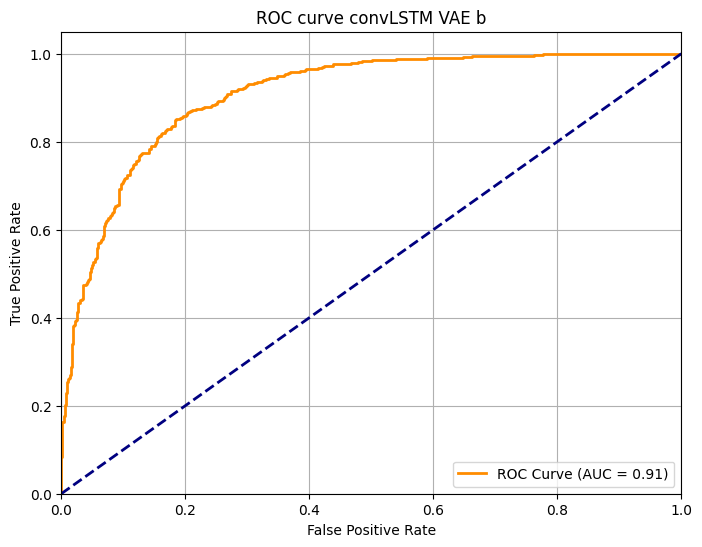

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(adjusted_y_true_binary, adjusted_reconstruction_errors)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve convLSTM VAE b")
plt.legend(loc="lower right")
plt.grid()
plt.show()

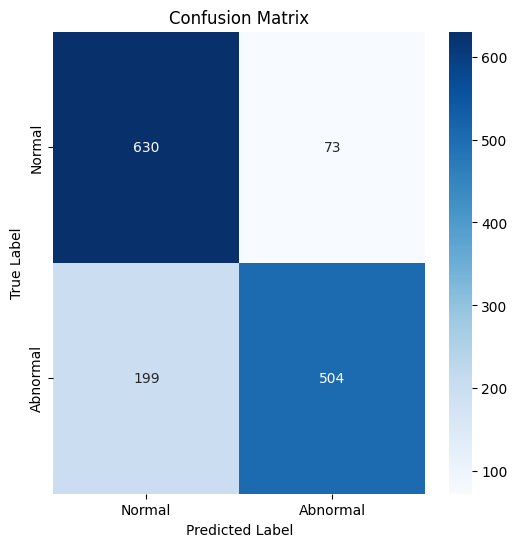

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(adjusted_y_true_binary, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

### Other method

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Convert reconstruction errors and labels to arrays
reconstruction_errors = np.array(reconstruction_errors)
y_true = np.array(y_true)

# Map labels to binary (0: Normal, 1: Abnormal)
label_mapping = {'N': 0, 'A': 1}
y_true_binary = np.array([label_mapping[label] for label in y_true])



# Set threshold for anomaly detection (mean + k * std)
mean_error = np.mean(reconstruction_errors)
std_error = np.std(reconstruction_errors)

In [ ]:
# Try multiple thresholds
for k in [0.5,1, 2, 2.5, 3, 3.5]:
    threshold = mean_error + k * std_error
    y_pred_binary = (reconstruction_errors > threshold).astype(int)  # Binary predictions

    # Compute confusion matrix and classification report
    print(f"\nFor k = {k}:")
    print('Confusion Matrix:')
    print(confusion_matrix(y_true_binary, y_pred_binary))

    print('Classification Report:')
    print(classification_report(y_true_binary, y_pred_binary, target_names=['Normal', 'Abnormal']))



For k = 0.5:
Confusion Matrix:
[[537 166]
 [488 215]]
Classification Report:
              precision    recall  f1-score   support

      Normal       0.52      0.76      0.62       703
    Abnormal       0.56      0.31      0.40       703

    accuracy                           0.53      1406
   macro avg       0.54      0.53      0.51      1406
weighted avg       0.54      0.53      0.51      1406


For k = 1:
Confusion Matrix:
[[617  86]
 [576 127]]
Classification Report:
              precision    recall  f1-score   support

      Normal       0.52      0.88      0.65       703
    Abnormal       0.60      0.18      0.28       703

    accuracy                           0.53      1406
   macro avg       0.56      0.53      0.46      1406
weighted avg       0.56      0.53      0.46      1406


For k = 2:
Confusion Matrix:
[[678  25]
 [666  37]]
Classification Report:
              precision    recall  f1-score   support

      Normal       0.50      0.96      0.66       703
    Abn

In [ ]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true_binary, reconstruction_errors)
roc_auc = auc(fpr, tpr)

# Find the optimal threshold (Youden's J statistic)
j_scores = tpr - fpr
best_threshold = thresholds[np.argmax(j_scores)]
print(f"Optimal threshold based on ROC curve: {best_threshold}")

# Classify using the optimal threshold
y_pred_binary = (reconstruction_errors > best_threshold).astype(int)

# Final confusion matrix and classification report
print('\nUsing Optimal Threshold:')
print('Confusion Matrix:')
print(confusion_matrix(y_true_binary, y_pred_binary))

print('Classification Report:')
print(classification_report(y_true_binary, y_pred_binary, target_names=['Normal', 'Abnormal']))


Optimal threshold based on ROC curve: 0.34039929509162903

Using Optimal Threshold:
Confusion Matrix:
[[461 242]
 [392 311]]
Classification Report:
              precision    recall  f1-score   support

      Normal       0.54      0.66      0.59       703
    Abnormal       0.56      0.44      0.50       703

    accuracy                           0.55      1406
   macro avg       0.55      0.55      0.54      1406
weighted avg       0.55      0.55      0.54      1406



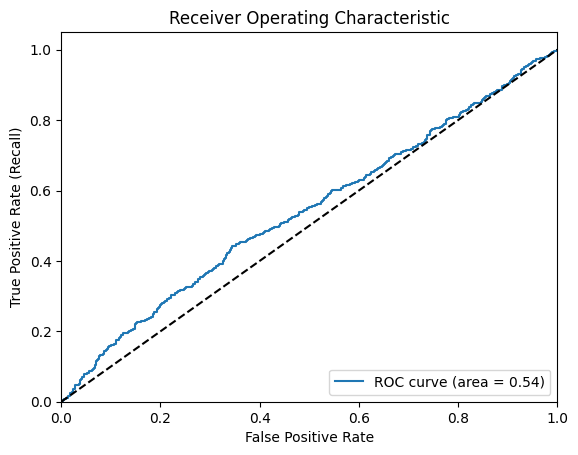

In [ ]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### visualisation

In [9]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Preprocess a single video for the model
def preprocess_single_video(video_path, sequence_size=30, image_width=112, image_height=112):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while len(frames) < sequence_size:
        ret, frame = cap.read()
        if not ret:
            break

        # Resize frame
        frame = cv2.resize(frame, (image_width, image_height))
        # Convert to grayscale
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # Normalize to [0, 1]
        frame = frame.astype(np.float32) / 255.0
        # Add a channel dimension (height, width, 1)
        frame = np.expand_dims(frame, axis=-1)

        frames.append(frame)

    cap.release()

    # Pad with zeros if fewer frames than sequence_size
    while len(frames) < sequence_size:
        frames.append(np.zeros((image_height, image_width, 1)))

    # Convert to numpy array with shape (1, sequence_size, image_height, image_width, 1)
    video_sequence = np.expand_dims(np.array(frames), axis=0)
    return video_sequence, len(frames)

In [7]:
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import LogNorm

# Display all frames and their corresponding heatmaps
def display_frames_with_heatmaps_side_by_side(video_sequence, reconstructed_frames, sequence_length):
    # Reshape reconstructed_frames if necessary
    if reconstructed_frames.ndim == 2:  # Flattened output
        batch_size, seq_len, height, width, channels = video_sequence.shape
        reconstructed_frames = reconstructed_frames.reshape(batch_size, seq_len, height, width, channels)

    # Set up the plot dimensions
    fig, axes = plt.subplots(2, sequence_length, figsize=(sequence_length * 3, 6))

    for frame_idx in range(sequence_length):
        # Extract the original frame and reconstructed frame
        original_frame = video_sequence[0, frame_idx, :, :, 0]  # Remove batch and channel dimensions
        reconstructed_frame = reconstructed_frames[0, frame_idx, :, :, 0]

        # Calculate reconstruction error for this frame
        frame_error = np.square(original_frame - reconstructed_frame)

        # Plot the original frame
        axes[0, frame_idx].imshow(original_frame, cmap='grey')
        axes[0, frame_idx].axis('off')
        # Modify the jet colormap to set black for 0
        #jet_colors = plt.cm.jet(np.linspace(0, 1, 256))
        #jet_colors[0] = [0, 0, 0, 1]  # Replace the first color (for 0) with black (RGBA)
        #custom_jet = LinearSegmentedColormap.from_list('custom_jet', jet_colors)

        # Plot the reconstruction error heatmap
        axes[1, frame_idx].imshow(frame_error, cmap='jet',)
        axes[1, frame_idx].axis('off')

    plt.tight_layout()
    plt.show()



In [ ]:
# Define model and video path
#video_path = '/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/Videos/0X129133A90A61A59D.avi'
#video_path = '/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/Videos/0X1002E8FBACD08477.avi'
video_path = '/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/Videos/0X1002E8FBACD08477.avi'
#video_path = '/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/Videos/0X2FD727869D3D7132.avi'
sequence_size = 30  # Number of frames your model expects
image_width, image_height = 112, 112  # Dimensions of each frame


# Preprocess the video
video_sequence, valid_frame_count = preprocess_single_video(video_path, sequence_size, image_width, image_height)

# Get the reconstructed frames from the model
reconstructed_frames = model.predict(video_sequence)

# Display all frames with corresponding heatmaps side by side
display_frames_with_heatmaps_side_by_side(video_sequence, reconstructed_frames, valid_frame_count)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Define model and video path
#video_path = '/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/Videos/0X129133A90A61A59D.avi'
#video_path = '/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/Videos/0X1878080DBC95E7FC.avi'
#video_path = '/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/Videos/0X3F97ED7FEAA2AC6E.avi'
#video_path = '/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/Videos/0X4B58EABEDE38896B.avi'
#video_path = '/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/Videos/0X5D3BE1C6F1BDBF8.avi'
video_path = '/content/drive/MyDrive/kaggle_data/input/echonet-dynamic/EchoNet-Dynamic/Videos/0X5D98E2C64E1625FB.avi'

sequence_size = 30  # Number of frames your model expects
image_width, image_height = 112, 112  # Dimensions of each frame


# Preprocess the video
video_sequence, valid_frame_count = preprocess_single_video(video_path, sequence_size, image_width, image_height)

# Get the reconstructed frames from the model
reconstructed_frames = model.predict(video_sequence)

# Display all frames with corresponding heatmaps side by side
display_frames_with_heatmaps_side_by_side(video_sequence, reconstructed_frames, valid_frame_count)